**Temat:** Analiza sentymentu w tekstach internetowych w oparciu o sieci typu Transformer

**Wprowadzenie:** Analiza sentymentu to technika przetwarzania języka naturalnego (NLP), która identyfikuje ton emocjonalny w tekście, klasyfikując go na pozytywny, negatywny lub neutralny. Wykorzystuje się ją do badania opinii klientów, monitorowania reputacji marki czy analizy treści mediów społecznościowych.

**Cel projektu:** Celem projektu jest opracowanie i implementacja modelu analizy sentymentu, który pozwoli na klasyfikację opinii użytkowników na podstawie tekstów pochodzących z Internetu. Należy przeanalizować dane tekstowe, przygotować odpowiedni model oraz zaprezentować wyniki analizy.

In [12]:
!pip3 install datasets transformers 

### Ładowanie danych

In [13]:
from datasets import load_dataset

ds = load_dataset("clapAI/MultiLingualSentiment")

In [14]:
# what languages are available
languages = ds['train'].unique('language')
print("Available languages:", languages)
ds_types = ['train', 'validation', 'test']
# Create dictionary to store datasets for each language
datasets_by_language = {}

# # Split train, validation and test for each language
for lang in languages:
    datasets_by_language[lang] = {}
    for ds_type in ds_types:
        datasets_by_language[lang][ds_type] = ds[ds_type].filter(
            lambda batch: [x == lang for x in batch['language']],
            batched = True,
            num_proc=4
            )
        
        # Reduce dataset by 100 times
        rows_counter = datasets_by_language[lang][ds_type].num_rows
        new_num_rows = round(rows_counter*0.01)
        datasets_by_language[lang][ds_type] = datasets_by_language[lang][ds_type].shuffle(seed=42)
        datasets_by_language[lang][ds_type] = datasets_by_language[lang][ds_type].select(range(new_num_rows))
    

Available languages: ['en', 'es', 'ja', 'ar', 'tr', 'fr', 'vi', 'zh', 'de', 'ru', 'ko', 'id', 'multilingual', 'pt', 'ms', 'hi', 'it']


### Tworzenie testowego datasetu

In [15]:
from datasets import concatenate_datasets

test_languages = ['en', 'es', 'zh']
test_ds_list = [datasets_by_language[lang]['test'] for lang in test_languages]
test_dataset = concatenate_datasets(test_ds_list)

## Zero-shot Prompting

In [ ]:
!pip3 install accelerate 'numpy<2' torch

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


model_name = 'Qwen/Qwen3-0.6B'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# For MacBooks with CPU Intel you have to set device_map as cpu and torch_dtype as torch.float32 
# otherwise it doesn't compile
zero_shot_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    device_map={"": "cpu"})
zero_shot_model.eval()

/Users/michalklos/Studia_Projekty/NLP/Multilingual-sentiment-analysis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [2]:
# Prompt template
def build_prompt(text):
    return f"Just define in one word the sentiment of this text as positive, negative or neutral:\n\"{text}\"\nAnswer(positive/negative/neutral):\n"

def predict_sentiment(text):
    prompt = build_prompt(text)
    zero_shot_model_inputs = tokenizer(prompt, return_tensors="pt").to(zero_shot_model.device)
    generated_ids = zero_shot_model.generate(**zero_shot_model_inputs, max_new_tokens=3)
    answer = tokenizer.batch_decode(generated_ids)[0][len(prompt):]
    return answer

In [ ]:
print(test_dataset[0]['text'])
print(predict_sentiment(test_dataset[0]['text']))
print(f'\nReal answer:\n{test_dataset[0]['label']}')

### Test Zero-shot prompting

In [ ]:

# Mapping dataset and get estimates from LLM
def process(result, row):
    text = row['text']
    answer = predict_sentiment(text)
    if row['label'] in answer:
        result[row['language']] += 1

# Calculate total and for each language accuracy
def calc_accuracy(result, ds):
    accuracy = {}
    for lang in result:
        lang_total = ds.filter(
            lambda batch: [x == lang for x in batch['language']],
            batched = True,
            num_proc = 4
        ).num_rows
        accuracy[lang] = result[lang]/lang_total
    total_accuracy = sum(result.values()) / ds.num_rows
    accuracy['total'] = total_accuracy
    return accuracy


In [ ]:
zero_shot_results = {lang:0 for lang in test_languages}
test_dataset.map(lambda row: process(zero_shot_results, row))
zero_shot_accuracy = calc_accuracy(zero_shot_results, test_dataset)

Dokładność dla zero-shot prompting

In [ ]:
print(f"{'Język':<10} {'Dokładność':<10}")
print('-' * 22)
for lang, acc in zero_shot_accuracy.items():
    print(f"{lang:<10} {acc:<10.2f}")

    

### LoRA

### Wizualizacja danych

#### Preprocessing

In [ ]:
!python3 -m pip install certifi
!export SSL_CERT_FILE=$(python3 -m certifi)

In [3]:
!pip3 install nltk spacy --quiet
!python3 -m spacy download en_core_web_sm --quiet
!python3 -m spacy download es_core_news_sm --quiet
!python3 -m spacy download zh_core_web_sm --quiet


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "/Users/michalklos/Studia_Projekty/NLP/Multilingual-sentiment-analysis/.venv/lib/python3.11/site-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/Users/michalklos/Studia_Projekty/NLP/Multilingual-sentiment-analysis/.venv/lib/python3.11/site-packages/spacy/errors.py", line 3, in <module>
   

In [4]:
import re
import nltk
import spacy
from nltk.corpus import stopwords

Opcjonalne: przy problemach nltk z SSL:

In [5]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [6]:
nltk.download('stopwords')

# Initialize spacy models
nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'es': spacy.load('es_core_news_sm'),
    'zh': spacy.load('zh_core_web_sm')
}

# Get stopwords
stop_words = {
    'en': set(stopwords.words('english')),
    'es': set(stopwords.words('spanish')),
    'zh': set()  # Chinese doesn't use stopwords
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michalklos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def remove_special_and_digits(txt, lang):
  txt = re.sub(r'[^a-zA-Z\u4e00-\u9fff\s]', '', txt)

  if lang != 'zh':
    txt = txt.lower()
  
  document = nlp_models[lang](txt)

  tokens = []
  for token in document:
    if (token.text not in stop_words.get(lang, set()) and not token.is_space and 
      len(token.text.strip()) > 0):
      tokens.append(token.lemma_)
  
  return ' '.join(tokens)

def preprocess_dataset(example):
    example['preprocessed_text'] = remove_special_and_digits(
        example['text'], 
        example['language']
    )

    return example


In [24]:
print(test_dataset[:5]['language'])
print(test_dataset[:5]['text'])
print(test_dataset[:5]['label'])

preprocessed_dataset = test_dataset.map(
    preprocess_dataset, 
    num_proc=4, 
    batch_size=100
)

print("Original text:", preprocessed_dataset[0]['text'])
print("Preprocessed text:", preprocessed_dataset[0]['preprocessed_text'])

['en', 'en', 'en', 'en', 'en']
['Biden turns to Wall Street for campaign funds', 'Bu bölge içinde en fazla buluntu Şanlıurfa civarıdır.', 'Versay Barış Antlaşması sonucu Polonya vatandaşı oldu.', 'Google map is really helpful.thumbs-up to google. But the recent update with new color scheme is bad experience. Also it requires too much zoom in and out to see traffic on inner streets and surrounding areas. It was very easy before update.', 'i really did start to feel horrible once that nd beer kicked in']
['neutral', 'neutral', 'neutral', 'positive', 'negative']
Original text: Biden turns to Wall Street for campaign funds
Preprocessed text: biden turn wall street campaign fund


In [23]:
languages2 = test_dataset.unique('language')
print("Available languages in preprocessed dataset:", languages2)

Flattening the indices: 100%|██████████| 2186/2186 [00:00<00:00, 18176.81 examples/s]

Available languages in preprocessed dataset: ['en', 'es', 'zh']


In [25]:
!pip3 install matplotlib wordcloud

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_10_9_x86_64.whl.metadata (6.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 21.2 MB/s eta 0:00:0000:0100:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.3 MB/s eta 0:00:00ta 0:00:01
Using cached kiwisolver-1.4.8-cp311-cp311-macosx_10_9_x86_64.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [wordcloud]/8 [matplotlib]


Filter: 100%|██████████| 2186/2186 [00:00<00:00, 30379.31 examples/s]


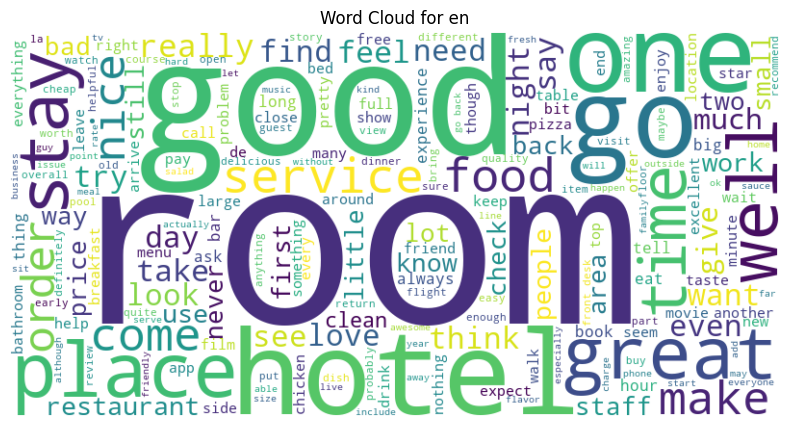

Filter: 100%|██████████| 2186/2186 [00:00<00:00, 63544.78 examples/s]


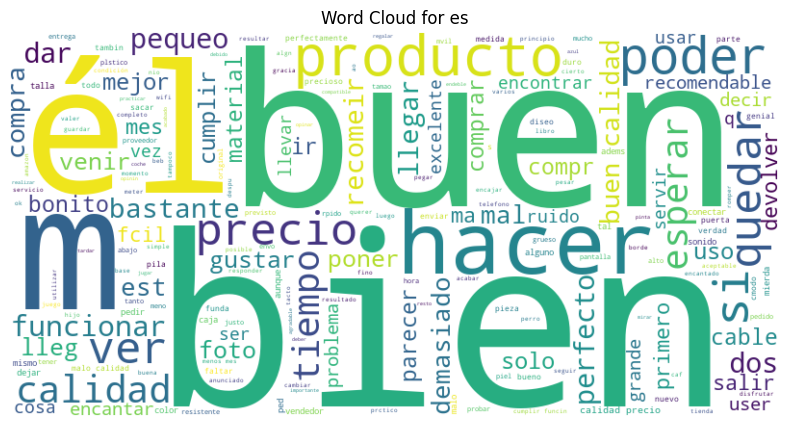

Filter: 100%|██████████| 2186/2186 [00:00<00:00, 90878.67 examples/s]


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [26]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create word cloud for each language
for lang in test_languages:
    # Filter dataset by language
    lang_texts = ' '.join(preprocessed_dataset.filter(
        lambda x: x['language'] == lang
    )['preprocessed_text'])
    
    # Create and display word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white'
    ).generate(lang_texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {lang}')
    plt.show()